In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-03-21 17:13:20,557 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/newLOO/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array(['../../results/newLOO/A-crossval-swarm_12-005_2018-01-30_07-25-57.pickle',
       '../../results/newLOO/A-crossval-swarm_51-009_2018-02-04_13-46-32.pickle',
       '../../results/newLOO/A-crossval-swarm_52-001_2018-02-04_13-54-32.pickle',
       '../../results/newLOO/A-crossval-swarm_TB_2018-02-07_01-59-30.pickle',
       '../../results/newLOO/C-crossval-swarm_12-005_2018-01-30_17-00-54.pickle',
       '../../results/newLOO/C-crossval-swarm_51-009_2018-01-30_17-55-55.pickle',
       '../../results/newLOO/C-crossval-swarm_52-001_2018-01-30_17-59-15.pickle',
       '../../results/newLOO/C-crossval-swarm_TB_2018-02-06_17-41-35.pickle',
       '../../results/newLOO/C2-crossval-swarm_51-009_2018-03-01_18-10-40.pickle',
       '../../results/newLOO/D-crossval-swarm_12-005_2018-02-03_06-45-33.pickle',
       '../../results/newLOO/D-crossval-swarm_51-009_2018-02-03_06-46-14.pickle',
       '../../results/newLOO/D-crossval-swarm_52-001_2018-02-03_06-46-52.pickle',
       '../../results/n

In [59]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = {
    'A': 'Scoreboard',
    'B': 'Scoreboard + visual field',
    'C': 'Axon map (Devyani)',
    'C2': 'Axon map + OD',
    'D': 'Axon map (Devyani) + visual field',
    'D2': 'Axon map + visual field + OD',
    'E': 'Axon map',
    'E2': 'Axon map + OD',
    'F': 'Axon map + visual field map',
    'F2': 'Axon map + visual field map + OD'
}
assert_params = {
    'amplitude': 2.0,
    'w_scale': 20,
    'w_rot': 0,
    'w_dice': 80
}

In [4]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
drawing_error = {s: {} for s in subjects}
idx_el = {s: None for s in subjects}
for subject in subjects:
    print('Calculating drawing error: %s' % subject)
    X, y = argus_shapes.load_data(os.path.join(rootfolder, subject), subject=subject, electrodes=None,
                                amplitude=assert_params['amplitude'], random_state=42,
                                single_stim=True, verbose=False)
    assert len(X) == len(y) != 0
    for e in X.electrode.unique():
        drawings = y[X['electrode'] == e]
        props = [argus_shapes.imgproc.get_region_props(d['image'], thresh=0.5) 
                 for _, d in drawings.iterrows()]
        area = np.std([p.area for p in props])
        err = np.array([np.rad2deg(np.abs(p.orientation)) for p in props])
        err = np.where(err > 180, 360 - err, err)
        orient = np.var(err)
        major_axis = np.var([p.major_axis_length for p in props])
        minor_axis = np.var([p.minor_axis_length for p in props])
        drawing_error[subject][e] = {'area': np.maximum(1, area), 
                                     'orientation': np.maximum(np.pi/180, orient),
                                     'major_axis_length': np.maximum(1, major_axis),
                                     'minor_axis_length': np.maximum(1, minor_axis)}
    X, y = argus_shapes.transform_mean_images(X, y)
    idx_el[subject] = np.array(X.electrode)

Calculating drawing error: 12-005
Calculating drawing error: 51-009
Calculating drawing error: 52-001
Calculating drawing error: TB


In [5]:
def calc_props_loss(ytyp, specifics, drawing_error, idx_el):
    y_true, y_pred = ytyp
    subject = specifics['subject']
    model = specifics['regressor']
    
    area = []
    orient = []
    for (iyt, yt), (iyp, yp), el in zip(y_true.iterrows(), y_pred.iterrows(), idx_el[subject]):
        if 'image' in yt:
            yt_props = argus_shapes.imgproc.get_region_props(yt['image'], thresh=0.5)
            yt_area = yt_props.area
            yt_orient = yt_props.orientation
        else:
            yt_area = yt['area']
            yt_orient = yt['orientation']

        if 'image' in yp:
            yp_props = argus_shapes.imgproc.get_region_props(yp['image'], thresh=model.img_thresh)
            if yp_props is None:
                yp_area = 0
                yp_orient = 0
            else:
                yp_area = yp_props.area
                yp_orient = yp_props.orientation
        else:
            yp_area = yp['area']
            yp_orient = yp['orientation']
        assert iyt == iyp
        assert el in drawing_error[subject]

        # Calc relative error: area
        err = ((yt_area - yp_area) ** 2) #/ drawing_error[subject][el]['area']
        area.append(err)
        
        # Calc relative error: orientation
        err = np.rad2deg(np.abs(yt_orient - yp_orient))
        err = 360 - err if err > 180 else err
        err = (err ** 2) #/ drawing_error[subject][el]['orientation']
        orient.append(err)
        
    return {'area': area, 'orientation': orient}

In [6]:
loss = {a: {s: None for s in subjects} for a in models}
for file in pickle_files:
    y_test, y_pred, best_params, specifics = pickle.load(open(file, 'rb'))
    for key, value in six.iteritems(assert_params):
        assert np.isclose(specifics[key], value)
    n_folds = specifics['n_folds']
    assert len(y_pred) == n_folds
    assert len(y_test) == n_folds
    assert len(best_params) == n_folds
    model = specifics['modelname']
    subject = specifics['subject']
    if model not in models:
        print('Model %s found, skip.' % model)
        continue
    if subject not in subjects:
        print('Subject %s found, skip.' % subject)
        continue
    print('Processing Model %s, Subject %s' % (model, subject))
    
    loss[model][subject] = p2pu.parfor(calc_props_loss, zip(y_test, y_pred), 
                                       func_args=[specifics, drawing_error, idx_el])

Processing Model A, Subject 12-005
Processing Model A, Subject 51-009
Processing Model A, Subject 52-001
Processing Model A, Subject TB
Processing Model C, Subject 12-005
Processing Model C, Subject 51-009
Processing Model C, Subject 52-001
Processing Model C, Subject TB
Processing Model C2, Subject 51-009
Processing Model D, Subject 12-005
Processing Model D, Subject 51-009
Processing Model D, Subject 52-001
Processing Model D, Subject TB
Processing Model D2, Subject 12-005
Processing Model D2, Subject 51-009
Processing Model D2, Subject 52-001
Processing Model D2, Subject TB
Processing Model E2, Subject 12-005
Processing Model E2, Subject TB
Processing Model F2, Subject TB


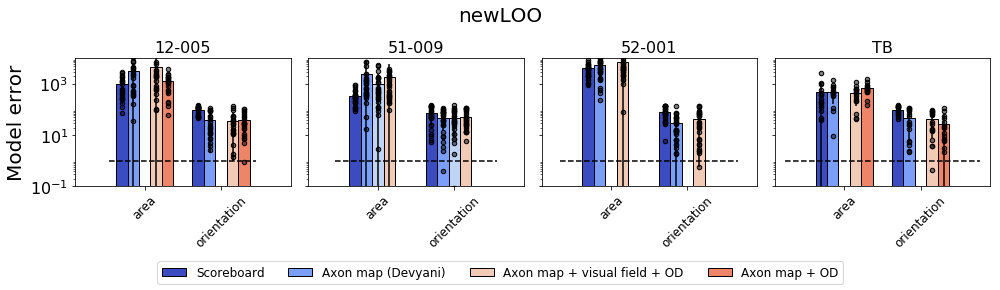

In [60]:
plot_models = ['A', 'C', 'C2', 'D2', 'E2']
cols = ['area', 'orientation']
N = len(cols)
width = 0.3 / N
ind = np.arange(N)

fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 4), sharex=True, sharey=True)
cm = plt.get_cmap('coolwarm')

show_ylabel = True
for ax, subject in zip(axes.ravel(), subjects):
    rects = {}
    for m, model in enumerate(plot_models):
        pcolor = list(cm(m / len(plot_models)))
        for c, col in enumerate(cols):
            if not loss[model][subject]:
                continue
            attr = [l[col] for l in loss[model][subject]]
            attr = [item for sublist in attr for item in sublist]
            r = ax.bar(c + m * width, np.mean(np.sqrt(attr)), width, yerr=np.std(np.sqrt(attr)), 
                       color=pcolor, edgecolor='k')
            ax.scatter(np.ones_like(attr) * (c + m * width), np.sqrt(attr), color=(0, 0, 0, 0.5),
                       edgecolor='k', zorder=5, s=20)
            rects[model] = r[0]
    a = ax.axis()
    ax.plot([a[0], a[1]], [1, 1], 'k--')
    if show_ylabel:
        ax.set_ylabel('Model error', fontsize=20)
        show_ylabel = False
    ax.set_xticks(ind + 0.5 * width * (len(plot_models) - 1))
    ax.set_xticklabels(cols, rotation=45, ha='center', fontsize=12)
    ax.set_yscale('log')
    ax.set_ylim(0.1, 10000)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title('%s' % subject, fontsize=16)
fig.suptitle(os.path.basename(os.path.dirname(results_dir)), fontsize=20)
fig.legend([rects[m] for m in plot_models if m in rects],
           [models[m] for m in plot_models if m in rects], 
          ncol=4, loc='lower center', fontsize=12)
fig.tight_layout(rect=[0, 0.1, 1, 0.9])
fig.savefig(os.path.join(results_dir, 'mse_props_loss.png'))

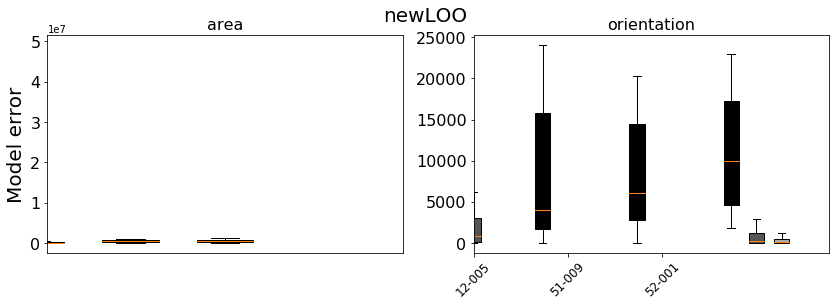

In [72]:
plot_models = ['A', 'E2', 'F2']
columns = ['area', 'orientation']
N = len(plot_models)
width = 0.8 / N
ind = np.arange(N)

fig, axes = plt.subplots(ncols=len(columns), figsize=(14, 4), sharex=True, sharey=False)
cm = plt.get_cmap('gray')

show_ylabel = True
for ax, col in zip(axes.ravel(), columns):
    rects = {}
    for m, model in enumerate(plot_models):
        pcolor = list(cm(m / len(plot_models)))
        alldata = []
        pos = []
        for s, subject in enumerate(subjects):
            if not loss[model][subject]:
                continue
            attr = [l[col] for l in loss[model][subject]]
            attr = [item for sublist in attr for item in sublist]
            alldata.append(attr)
            pos.append(s + m * width)
#             r = ax.bar(s + m * width, np.mean(np.sqrt(attr)), width, yerr=np.std(np.sqrt(attr)), 
#                        color=pcolor, edgecolor='w', linewidth=2,
#                        label='Model %s' % model)
#             ax.scatter(np.ones_like(attr) * (s + m * width), np.sqrt(attr), color=(0, 0, 0, 0.5),
#                        edgecolor='k', zorder=5, s=20)
        bp = ax.boxplot(alldata, positions=pos, widths=0.6 * width, notch=False, 
                        showfliers=False, vert=True, patch_artist=True)
        [b.set_facecolor(pcolor) for b in bp['boxes']]
        rects[model] = bp
#             rects[model] = r[0]
#     a = ax.axis()
#     ax.plot([a[0], a[1]], [1, 1], 'k--')
    if show_ylabel:
        ax.set_ylabel('Model error', fontsize=20)
        show_ylabel = False
    ax.set_xticks(ind + 0.5 * width * (len(plot_models) - 1))
    ax.set_xticklabels(subjects, rotation=45, ha='center', fontsize=12)
#     ax.set_yscale('log')
#     ax.set_ylim(0.1, 10000)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title('%s' % col, fontsize=16)
fig.suptitle(os.path.basename(os.path.dirname(results_dir)), fontsize=20)
# fig.legend([rects[m] for m in models if m in rects],
#            [models[m] for m in models if m in rects], 
#           ncol=4, loc='lower center', fontsize=12)
# fig.tight_layout(rect=[0, 0.1, 1, 0.9])
fig.savefig(os.path.join(results_dir, 'mse_props_loss2.png'))

In [64]:
bp

{'boxes': [<matplotlib.patches.PathPatch at 0x7fc0f8868dd8>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc0f88198d0>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc0f6781c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc0f8819860>,
  <matplotlib.lines.Line2D at 0x7fc0f8819a20>]}

In [66]:
ax.bar(0, 3)[0]

In [74]:
import seaborn as sns

In [76]:
import pandas as pd

In [77]:
pd.DataFrame(loss['A']['TB'])

,area,orientation
0,[7017201],[20419.1529165]
1,[7921],[16235.6602398]
2,[203401],[1856.79148618]
3,[33124],[2795.05209412]
4,[1234321],[23004.3328964]
5,[24025],[12393.2754835]
6,[17424],[4595.50806348]
7,[2304],[19497.576884]
8,[1521],[6808.93367726]
9,[65536],[7186.04833832]


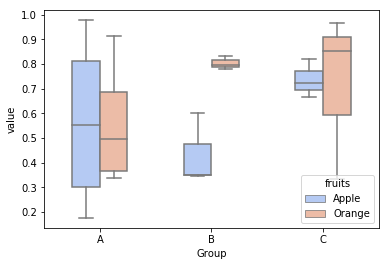

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dd=pd.melt(df, id_vars=['Group'], value_vars=['Apple','Orange'], var_name='fruits')
sns.boxplot(x='Group', y='value', data=dd, hue='fruits', palette='coolwarm', width=0.5)